# Persistence Images

This notebook demonstrates basic usage of the PerImage class.

In [1]:
%load_ext autoreload
%autoreload 2

## Generate a persistence diagram with Ripser 

In [3]:
from itertools import product

import numpy as np
from sklearn import datasets
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

from ripser import Rips
from persimmon import PersImage

## Generate persistence diagram using Ripser

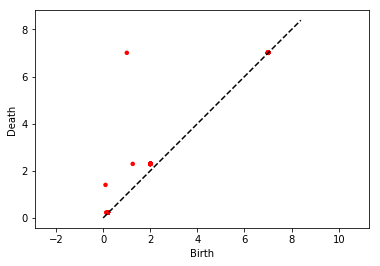

In [4]:
data = np.concatenate([datasets.make_circles(n_samples=100)[0], 
                       10 * datasets.make_circles(n_samples=100)[0]])
rips = Rips()
dgm = rips.fit_transform(data)
diagram = dgm[1]
rips.plot(diagram)

## Convert diagram to persistence image 

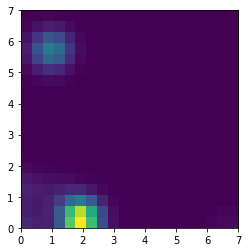

In [5]:
pim = PersImage(diagram)
img = pim.transform()
pim.show(img)